In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import cross_val_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('ml_data.csv').drop_duplicates()

In [4]:
df.head(3)

,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM,TOTAL_FLOOR
0,J71214794,flat,Bhawani bandhan,Madhyamgram,2.0,1.0,920,4239.0,0.39,Old Property,Unfurnished,246.0,1,11.0
1,F70835394,flat,Ganguly 4sight desire,Garia,1.0,1.0,535,5100.0,0.27,Old Property,Unfurnished,246.0,1,7.0
2,P69854924,flat,Dtc capital city,Rajarhat,4.0,2.0,1940,4742.0,0.92,Old Property,Unfurnished,246.0,1,20.0


In [5]:
df.columns

Index(['PROP_ID', 'PROPERTY_TYPE', 'SOCIETY_NAME', 'location', 'BEDROOM_NUM',
       'BALCONY_NUM', 'AREA', 'Price_per_sqft', 'PRICE', 'AGE', 'FURNISH',
       'amenity_luxury', 'FLOOR_NUM', 'TOTAL_FLOOR'],
      dtype='object')

In [6]:

def tansform_string(df, exclude=[], method='title'):
    # Define transformation methods
    transformation_methods = {
        'capitalize': lambda x: x.strip().capitalize() if isinstance(x, str) else x,
        'lower': lambda x: x.strip().lower() if isinstance(x, str) else x,
        'upper': lambda x: x.strip().upper() if isinstance(x, str) else x,
        'title': lambda x: x.strip().title() if isinstance(x, str) else x  # Title case
    }
    
    # Use the specified method, default to 'title'
    transform = transformation_methods.get(method, transformation_methods['title'])
    
    # Process all columns
    for column in df.columns:
        if column in exclude:
            # Strip only for excluded columns
            df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
        elif df[column].dtype == 'object':  
            df[column] = df[column].apply(transform)



In [7]:
tansform_string(df)

In [8]:
df

,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM,TOTAL_FLOOR
0,J71214794,Flat,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,4239.0,0.39,Old Property,Unfurnished,246.0,1,11.0
1,F70835394,Flat,Ganguly 4Sight Desire,Garia,1.0,1.0,535,5100.0,0.27,Old Property,Unfurnished,246.0,1,7.0
2,P69854924,Flat,Dtc Capital City,Rajarhat,4.0,2.0,1940,4742.0,0.92,Old Property,Unfurnished,246.0,1,20.0
3,E69854912,Flat,Dtc Capital City,Rajarhat,2.0,1.0,910,4615.0,0.42,Old Property,Unfurnished,246.0,1,20.0
4,R69167152,Flat,Sai Sarovaar,New Town,3.0,1.0,1163,4700.0,0.55,Old Property,Unfurnished,246.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5143,U71217472,Flat,Shyama Apartment,Behala,2.0,1.0,730,4520.0,0.33,Relatively New Property,Fully Furnished,307.0,2,2.0
5144,E64737128,Flat,Privet,New Alipore,3.0,1.0,2000,9000.0,1.80,Moderately Old,Luxury Furnished,192.0,2,5.0
5145,J66826540,Flat,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,8410.0,1.55,New Property,Luxury Furnished,135.0,14,19.0
5146,E66826562,Flat,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,8417.0,1.75,New Property,Luxury Furnished,135.0,10,19.0


#### dropping column SOCIETY_NAME,Price_per_sqft,PROPERTY_TYPE
because
- PROPERTY_TYPE --> all are flats
- Price_per_sqft,SOCIETY_NAME --> user will be unaware of that.

In [9]:
train_df = df.drop(columns=['PROPERTY_TYPE','Price_per_sqft','TOTAL_FLOOR','PROP_ID'])

In [10]:
train_df

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,246.0,1
1,Ganguly 4Sight Desire,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,246.0,1
2,Dtc Capital City,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,246.0,1
3,Dtc Capital City,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,246.0,1
4,Sai Sarovaar,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,246.0,1
...,...,...,...,...,...,...,...,...,...,...
5143,Shyama Apartment,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully Furnished,307.0,2
5144,Privet,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury Furnished,192.0,2
5145,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury Furnished,135.0,14
5146,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury Furnished,135.0,10


In [11]:
train_df['amenity_luxury'].describe()

count    5148.000000
mean      320.939588
std       210.759181
min         1.000000
25%       175.000000
50%       246.500000
75%       439.250000
max      1105.000000
Name: amenity_luxury, dtype: float64

### Converting amenity_luxury to categorical column

In [12]:
train_df['amenity_luxury'] = train_df['amenity_luxury'].apply(lambda x: 'Low' if x <=200 else 'Medium' if x <= 500 else 'High')

In [13]:
train_df

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,Medium,1
1,Ganguly 4Sight Desire,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,Medium,1
2,Dtc Capital City,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,Medium,1
3,Dtc Capital City,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,Medium,1
4,Sai Sarovaar,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,Medium,1
...,...,...,...,...,...,...,...,...,...,...
5143,Shyama Apartment,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully Furnished,Medium,2
5144,Privet,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury Furnished,Low,2
5145,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury Furnished,Low,14
5146,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury Furnished,Low,10


### Converting FLOOR_NUM to categorical column

In [14]:
train_df['FLOOR_NUM'].describe()

count    5148.000000
mean        4.346348
std         4.649759
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        34.000000
Name: FLOOR_NUM, dtype: float64

<Axes: ylabel='FLOOR_NUM'>

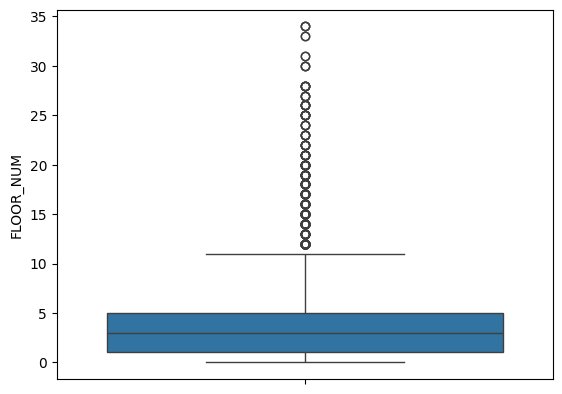

In [15]:
sns.boxplot(train_df['FLOOR_NUM'])

In [16]:
train_df['FLOOR_NUM'] = df['FLOOR_NUM'].apply(lambda x : 'Low Floor' if x <= 2 else 'Mid Floor' if x <= 10 else 'High Floor')

In [17]:
train_df

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,Medium,Low Floor
1,Ganguly 4Sight Desire,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,Medium,Low Floor
2,Dtc Capital City,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,Medium,Low Floor
3,Dtc Capital City,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,Medium,Low Floor
4,Sai Sarovaar,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,Medium,Low Floor
...,...,...,...,...,...,...,...,...,...,...
5143,Shyama Apartment,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully Furnished,Medium,Low Floor
5144,Privet,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury Furnished,Low,Low Floor
5145,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury Furnished,Low,High Floor
5146,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury Furnished,Low,Mid Floor


In [18]:
train_df

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,Medium,Low Floor
1,Ganguly 4Sight Desire,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,Medium,Low Floor
2,Dtc Capital City,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,Medium,Low Floor
3,Dtc Capital City,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,Medium,Low Floor
4,Sai Sarovaar,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,Medium,Low Floor
...,...,...,...,...,...,...,...,...,...,...
5143,Shyama Apartment,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully Furnished,Medium,Low Floor
5144,Privet,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury Furnished,Low,Low Floor
5145,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury Furnished,Low,High Floor
5146,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury Furnished,Low,Mid Floor


In [19]:
# Label encoding to all categorical columns
def ordinal_encoding(df, exclude=None):
    if exclude is None:
        exclude = []
    
    encoder = OrdinalEncoder()
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Exclude specified columns
    columns_to_encode = [col for col in categorical_columns if col not in exclude]
    
    # Apply encoding
    for column in columns_to_encode:
        df[column] = encoder.fit_transform(df[[column]])
    
    return df


In [20]:
data_label_encoded = train_df.copy()

In [21]:
data_label_encoded

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Bhawani Bandhan,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,Medium,Low Floor
1,Ganguly 4Sight Desire,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,Medium,Low Floor
2,Dtc Capital City,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,Medium,Low Floor
3,Dtc Capital City,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,Medium,Low Floor
4,Sai Sarovaar,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,Medium,Low Floor
...,...,...,...,...,...,...,...,...,...,...
5143,Shyama Apartment,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully Furnished,Medium,Low Floor
5144,Privet,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury Furnished,Low,Low Floor
5145,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury Furnished,Low,High Floor
5146,Ambuja Upohar The Condoville,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury Furnished,Low,Mid Floor


In [22]:
ordinal_encoding(data_label_encoded)

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,222.0,232.0,2.0,1.0,920,0.39,2.0,3.0,2.0,1.0
1,499.0,149.0,1.0,1.0,535,0.27,2.0,3.0,2.0,1.0
2,417.0,334.0,4.0,2.0,1940,0.92,2.0,3.0,2.0,1.0
3,417.0,334.0,2.0,1.0,910,0.42,2.0,3.0,2.0,1.0
4,1306.0,283.0,3.0,1.0,1163,0.55,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5143,1475.0,63.0,2.0,1.0,730,0.33,3.0,0.0,2.0,1.0
5144,1119.0,278.0,3.0,1.0,2000,1.80,0.0,1.0,1.0,1.0
5145,75.0,99.0,3.0,2.0,1843,1.55,1.0,1.0,1.0,0.0
5146,75.0,99.0,3.0,2.0,2079,1.75,1.0,1.0,1.0,2.0


In [23]:
x_label = data_label_encoded.drop(columns='PRICE')
y_label = data_label_encoded['PRICE']

In [24]:
x_label

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,222.0,232.0,2.0,1.0,920,2.0,3.0,2.0,1.0
1,499.0,149.0,1.0,1.0,535,2.0,3.0,2.0,1.0
2,417.0,334.0,4.0,2.0,1940,2.0,3.0,2.0,1.0
3,417.0,334.0,2.0,1.0,910,2.0,3.0,2.0,1.0
4,1306.0,283.0,3.0,1.0,1163,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
5143,1475.0,63.0,2.0,1.0,730,3.0,0.0,2.0,1.0
5144,1119.0,278.0,3.0,1.0,2000,0.0,1.0,1.0,1.0
5145,75.0,99.0,3.0,2.0,1843,1.0,1.0,1.0,0.0
5146,75.0,99.0,3.0,2.0,2079,1.0,1.0,1.0,2.0


In [25]:
y_label

0       0.39
1       0.27
2       0.92
3       0.42
4       0.55
        ... 
5143    0.33
5144    1.80
5145    1.55
5146    1.75
5147    0.74
Name: PRICE, Length: 5148, dtype: float64

## Technique 1: Corelation Analysis 

In [26]:
data_label_encoded.corr()

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
SOCIETY_NAME,1.000000,-0.021052,0.025654,0.021059,0.005602,0.014446,0.011735,-0.008891,0.029332,0.013044
location,-0.021052,1.000000,0.030878,0.048128,0.019555,0.002478,-0.027228,0.058701,0.010583,-0.065497
BEDROOM_NUM,0.025654,0.030878,1.000000,0.405632,0.765391,0.609508,-0.050754,0.090910,-0.020580,-0.062650
BALCONY_NUM,0.021059,0.048128,0.405632,1.000000,0.433120,0.298402,-0.034970,0.028081,-0.050470,-0.065509
AREA,0.005602,0.019555,0.765391,0.433120,1.000000,0.863859,-0.084192,0.061615,-0.073359,-0.100805
PRICE,0.014446,0.002478,0.609508,0.298402,0.863859,1.000000,-0.080005,0.086846,-0.056196,-0.123314
AGE,0.011735,-0.027228,-0.050754,-0.034970,-0.084192,-0.080005,1.000000,-0.160313,0.002642,0.017357
FURNISH,-0.008891,0.058701,0.090910,0.028081,0.061615,0.086846,-0.160313,1.000000,0.202921,-0.122310
amenity_luxury,0.029332,0.010583,-0.020580,-0.050470,-0.073359,-0.056196,0.002642,0.202921,1.000000,0.013320
FLOOR_NUM,0.013044,-0.065497,-0.062650,-0.065509,-0.100805,-0.123314,0.017357,-0.122310,0.013320,1.000000


<Axes: >

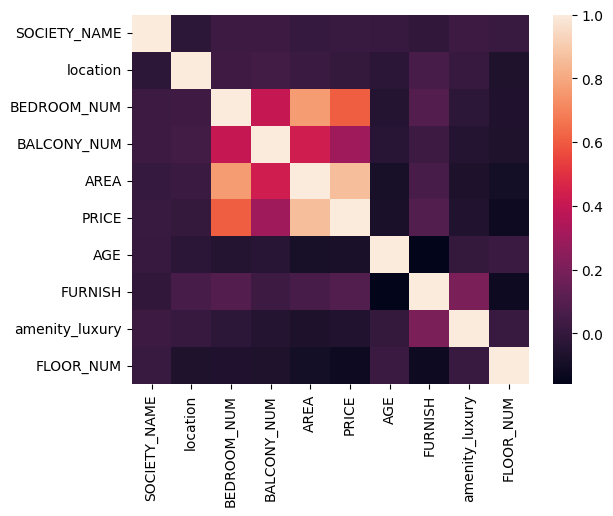

In [27]:
sns.heatmap(data_label_encoded.corr())

In [28]:
data_label_encoded.corr()

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
SOCIETY_NAME,1.000000,-0.021052,0.025654,0.021059,0.005602,0.014446,0.011735,-0.008891,0.029332,0.013044
location,-0.021052,1.000000,0.030878,0.048128,0.019555,0.002478,-0.027228,0.058701,0.010583,-0.065497
BEDROOM_NUM,0.025654,0.030878,1.000000,0.405632,0.765391,0.609508,-0.050754,0.090910,-0.020580,-0.062650
BALCONY_NUM,0.021059,0.048128,0.405632,1.000000,0.433120,0.298402,-0.034970,0.028081,-0.050470,-0.065509
AREA,0.005602,0.019555,0.765391,0.433120,1.000000,0.863859,-0.084192,0.061615,-0.073359,-0.100805
PRICE,0.014446,0.002478,0.609508,0.298402,0.863859,1.000000,-0.080005,0.086846,-0.056196,-0.123314
AGE,0.011735,-0.027228,-0.050754,-0.034970,-0.084192,-0.080005,1.000000,-0.160313,0.002642,0.017357
FURNISH,-0.008891,0.058701,0.090910,0.028081,0.061615,0.086846,-0.160313,1.000000,0.202921,-0.122310
amenity_luxury,0.029332,0.010583,-0.020580,-0.050470,-0.073359,-0.056196,0.002642,0.202921,1.000000,0.013320
FLOOR_NUM,0.013044,-0.065497,-0.062650,-0.065509,-0.100805,-0.123314,0.017357,-0.122310,0.013320,1.000000


In [29]:
fi_df1 = data_label_encoded.corr()['PRICE'].to_frame().reset_index().rename(columns={'index': 'feature','PRICE':'Corr_coef'}).sort_values(by= 'Corr_coef', ascending=False)

In [30]:
fi_df1

,feature,Corr_coef
5,PRICE,1.000000
4,AREA,0.863859
2,BEDROOM_NUM,0.609508
3,BALCONY_NUM,0.298402
7,FURNISH,0.086846
0,SOCIETY_NAME,0.014446
1,location,0.002478
8,amenity_luxury,-0.056196
6,AGE,-0.080005
9,FLOOR_NUM,-0.123314


## Technique 2: Randomforest Feature importance

In [31]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_label,y_label)
fi_df2 = pd.DataFrame({'feature': x_label.columns,
                      'rf_importance': rf.feature_importances_}).sort_values(by='rf_importance',ascending=False)

fi_df2

,feature,rf_importance
4,AREA,0.822425
1,location,0.056864
0,SOCIETY_NAME,0.052251
3,BALCONY_NUM,0.016386
8,FLOOR_NUM,0.012773
5,AGE,0.010902
6,FURNISH,0.010821
2,BEDROOM_NUM,0.010454
7,amenity_luxury,0.007124


## Technique 3: Gradient Boosting Feature importance

In [32]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(x_label, y_label)

# Extract feature importances
importances = gb.feature_importances_

# Create DataFrame for feature importances
fi_df3 = pd.DataFrame({
    'feature': x_label.columns,
    'gb_importance': importances
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
4,AREA,0.889309
0,SOCIETY_NAME,0.044412
1,location,0.038661
3,BALCONY_NUM,0.010305
8,FLOOR_NUM,0.009080
2,BEDROOM_NUM,0.003005
6,FURNISH,0.002757
5,AGE,0.001782
7,amenity_luxury,0.000689


## Technique 4: Recursive Feature Elimination (RFE)

In [33]:
x_label.shape

(5148, 9)

In [34]:

# Initialize the base estimator
estimator = GradientBoostingRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=x_label.shape[1], step=1)
selector_label = selector_label.fit(x_label, y_label)

# Get the selected features based on RFE
selected_features = x_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df4


,feature,rfe_score
4,AREA,0.889233
0,SOCIETY_NAME,0.044431
1,location,0.038609
3,BALCONY_NUM,0.010405
8,FLOOR_NUM,0.009085
2,BEDROOM_NUM,0.002980
6,FURNISH,0.002757
5,AGE,0.001798
7,amenity_luxury,0.000702


## Technique 5 - Permutation Importance

In [35]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_label, y_label, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

# Compute permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for feature importances
fi_df5 = pd.DataFrame({
    'feature': X_test.columns,
    'permutation_importance': result.importances_mean,
}).sort_values(by='permutation_importance', ascending=False)


fi_df5

,feature,permutation_importance
4,AREA,1.627673
1,location,0.041365
0,SOCIETY_NAME,0.039392
2,BEDROOM_NUM,0.021568
8,FLOOR_NUM,0.009670
6,FURNISH,0.008598
3,BALCONY_NUM,0.007458
5,AGE,0.004555
7,amenity_luxury,-0.000608


## Technique 6: SHAP 

In [36]:

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_label, y_label)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_label)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values


array([[-3.17547090e-02, -4.79518818e-02,  1.64302492e-02, ...,
         4.86840554e-02, -8.14364937e-04, -1.51345850e-02],
       [-1.22012955e-02,  1.10399546e-02, -3.43169768e-02, ...,
         6.28030043e-02,  2.59225959e-03, -9.28522290e-03],
       [-2.41462973e-01, -8.91268940e-02,  2.66538679e-02, ...,
        -2.09226314e-05,  1.01479161e-03, -5.01257549e-02],
       ...,
       [ 4.12126852e-02, -1.36785193e-02,  4.15599964e-02, ...,
         4.59438778e-03,  3.60911376e-03,  1.33618195e-01],
       [ 3.76426199e-02,  3.65399620e-03,  4.04193337e-02, ...,
         1.14684217e-02,  1.67164871e-03, -2.14770007e-02],
       [-6.55164570e-02,  1.50615141e-02,  9.71571882e-03, ...,
        -1.53868474e-02,  3.08154943e-02, -9.13549501e-03]])

In [37]:
# Step 1: Directly use shap_values as it is already a NumPy array
shap_values_array = shap_values  # No need to extract .values

# Step 2: Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

# Step 3: Create a DataFrame for feature importance
fi_df6 = pd.DataFrame({
    'feature': x_label.columns,   # Assuming x_label is your DataFrame with feature names as columns
    'SHAP_score': mean_abs_shap_values
}).sort_values(by='SHAP_score', ascending=False)

fi_df6


,feature,SHAP_score
4,AREA,0.532385
1,location,0.053369
0,SOCIETY_NAME,0.040272
8,FLOOR_NUM,0.032161
2,BEDROOM_NUM,0.028138
6,FURNISH,0.023515
3,BALCONY_NUM,0.020816
5,AGE,0.011308
7,amenity_luxury,0.008006


## Technique 7: XG Boost:

In [38]:


# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(x_label, y_label)

# Extract feature importances
fi_df7 = pd.DataFrame({
    'feature': x_label.columns,
    'xgb_importance': xgb_model.feature_importances_
}).sort_values(by='xgb_importance', ascending=False)

# Display the DataFrame
print(fi_df7)


          feature  xgb_importance
4            AREA        0.693794
1        location        0.059638
3     BALCONY_NUM        0.048830
0    SOCIETY_NAME        0.045457
8       FLOOR_NUM        0.039727
6         FURNISH        0.037089
5             AGE        0.032565
2     BEDROOM_NUM        0.027290
7  amenity_luxury        0.015608


In [56]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').set_index('feature')

In [57]:
final_fi_df

,Corr_coef,rf_importance,gb_importance,rfe_score,permutation_importance,SHAP_score,xgb_importance
feature,,,,,,,
AREA,0.863859,0.822425,0.889309,0.889233,1.627673,0.532385,0.693794
BEDROOM_NUM,0.609508,0.010454,0.003005,0.002980,0.021568,0.028138,0.027290
BALCONY_NUM,0.298402,0.016386,0.010305,0.010405,0.007458,0.020816,0.048830
FURNISH,0.086846,0.010821,0.002757,0.002757,0.008598,0.023515,0.037089
SOCIETY_NAME,0.014446,0.052251,0.044412,0.044431,0.039392,0.040272,0.045457
location,0.002478,0.056864,0.038661,0.038609,0.041365,0.053369,0.059638
amenity_luxury,-0.056196,0.007124,0.000689,0.000702,-0.000608,0.008006,0.015608
AGE,-0.080005,0.010902,0.001782,0.001798,0.004555,0.011308,0.032565
FLOOR_NUM,-0.123314,0.012773,0.009080,0.009085,0.009670,0.032161,0.039727


In [58]:
# adding column wise
column_sum = final_fi_df.sum(axis=0)
column_sum

Corr_coef                 1.616024
rf_importance             1.000000
gb_importance             1.000000
rfe_score                 1.000000
permutation_importance    1.759670
SHAP_score                0.749972
xgb_importance            1.000000
dtype: float64

In [59]:
final_fi_df = final_fi_df.divide(column_sum)
final_fi_df

,Corr_coef,rf_importance,gb_importance,rfe_score,permutation_importance,SHAP_score,xgb_importance
feature,,,,,,,
AREA,0.534558,0.822425,0.889309,0.889233,0.924988,0.709873,0.693794
BEDROOM_NUM,0.377165,0.010454,0.003005,0.002980,0.012257,0.037519,0.027290
BALCONY_NUM,0.184652,0.016386,0.010305,0.010405,0.004238,0.027756,0.048830
FURNISH,0.053740,0.010821,0.002757,0.002757,0.004886,0.031354,0.037089
SOCIETY_NAME,0.008939,0.052251,0.044412,0.044431,0.022386,0.053698,0.045457
location,0.001533,0.056864,0.038661,0.038609,0.023507,0.071162,0.059638
amenity_luxury,-0.034774,0.007124,0.000689,0.000702,-0.000346,0.010676,0.015608
AGE,-0.049507,0.010902,0.001782,0.001798,0.002589,0.015079,0.032565
FLOOR_NUM,-0.076307,0.012773,0.009080,0.009085,0.005495,0.042883,0.039727


In [95]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score','SHAP_score']].mean(axis=1).sort_values(ascending=False)

feature
AREA              0.847166
location          0.045761
SOCIETY_NAME      0.043436
FLOOR_NUM         0.015863
BALCONY_NUM       0.013818
BEDROOM_NUM       0.013243
FURNISH           0.010515
AGE               0.006430
amenity_luxury    0.003769
dtype: float64

In [90]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, x_label, y_label, cv=5, scoring='r2')
scores.mean()

0.9990284830935195

In [91]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, x_label.drop(columns=['AGE', 'amenity_luxury']), y_label, cv=5, scoring='r2')
scores.mean()

0.9992571100800264

In [92]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, x_label.drop(columns=['FURNISH', 'AGE', 'amenity_luxury']), y_label, cv=5, scoring='r2')
scores.mean()

0.9992078167085395

In [93]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, x_label.drop(columns=['FURNISH', 'AGE', 'amenity_luxury','BEDROOM_NUM',
                                                   'BALCONY_NUM','FLOOR_NUM']), y_label, cv=5, scoring='r2')
scores.mean()

0.9992846317328159

In [94]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, x_label.drop(columns=['FURNISH', 'AGE', 'amenity_luxury','BEDROOM_NUM','BALCONY_NUM',
                                                   'FLOOR_NUM','SOCIETY_NAME']), y_label, cv=5, scoring='r2')
scores.mean()

0.9992987106483631

In [49]:
x_label

,SOCIETY_NAME,location,BEDROOM_NUM,BALCONY_NUM,AREA,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,222.0,232.0,2.0,1.0,920,2.0,3.0,2.0,1.0
1,499.0,149.0,1.0,1.0,535,2.0,3.0,2.0,1.0
2,417.0,334.0,4.0,2.0,1940,2.0,3.0,2.0,1.0
3,417.0,334.0,2.0,1.0,910,2.0,3.0,2.0,1.0
4,1306.0,283.0,3.0,1.0,1163,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
5143,1475.0,63.0,2.0,1.0,730,3.0,0.0,2.0,1.0
5144,1119.0,278.0,3.0,1.0,2000,0.0,1.0,1.0,1.0
5145,75.0,99.0,3.0,2.0,1843,1.0,1.0,1.0,0.0
5146,75.0,99.0,3.0,2.0,2079,1.0,1.0,1.0,2.0


In [50]:
export_df = x_label
export_df['PRICE'] = y_label

In [51]:
export_df= export_df.drop(columns='PRICE')

KeyError: "['price'] not found in axis"

In [ ]:
export_df

In [ ]:
# export_df.to_csv('kolkata_flat_post_feature_selection.csv', index=False)